<a href="https://colab.research.google.com/github/sucrammal/vectari/blob/main/k_means_with_cleaning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install openai

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 324.1/324.1 kB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 3.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 7.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 6.5 MB/s eta 0:00:00


In [ ]:
!pip install nltk

In [ ]:
# Imports
import pandas as pd
import numpy as np
from openai import AzureOpenAI

# NLTK imports
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.stem import *

# skl imports
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.cluster import KMeans

nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')

from google.colab import drive
drive.mount('/content/drive')

import string

STOPWORD_SET = {'t', 'xxxx', 'XXXX', 'xx/xx/xxxx', 'xx/xx', 'their', 'should', "doesn't", 'under', 'wasn', 'on', 'needn', 'hadn', 'out', 'against', 'to', 'ours', 'them', 'was', 'then', 'few', 'after', 'can', 'over', "weren't", 'during', 'a', 'an', 'until', 'has', 'no', 'hers', 'only', "you've", "aren't", "didn't", 'me', 'if', 'which', "wasn't", 'does', 'these', 'how', 'll', 'for', 'because', 'm', 'ma', 'won', "you'll", 'yourselves', 'haven', 'were', 'he', 'is', 'each', 'why', 'you', 'did', 'yourself', 'from', 'been', 'more', 's', "hasn't", 'above', 'with', 'o', 'below', 'aren', 'it', 'now', 'ourselves', 'so', 'here', 'do', 'up', "it's", 'most', 'i', 'himself', 'y', 'we', 'again', 'yours', 'both', 'further', "isn't", 'and', 'than', 'of', 'hasn', 'into', 'or', "should've", 'whom', 'this', 'are', 'weren', 'what', "wouldn't", 're', 'she', 'herself', "you'd", 'same', 'having', 'by', 'where', 'they', 'off', 'about', 'shouldn', 'my', 'shan', 'as', 'isn', "mustn't", 'am', 'own', 'wouldn', 'those', "haven't", 'while', 'his', "that'll", 'between', 'its', 'but', 'being', 'itself', 'be', "needn't", 'don', 'at', 'mightn', 'doing', "you're", "she's", 'down', 'just', 'him', 'ain', 'mustn', 'theirs', 'very', "shan't", 'will', "hadn't", 'through', 'couldn', 'such', "won't", 'who', 'doesn', 've', 'when', 'not', 'myself', 'there', 'had', 'nor', 'other', "don't", 'her', "shouldn't", 'd', 'too', 'any', 'our', 'in', 'that', 'all', 'didn', 'themselves', 'before', 'the', "couldn't", 'your', "mightn't", 'once', 'some', 'have'}


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


Mounted at /content/drive


In [ ]:
from google.colab import userdata

# Setting up API
# gpt_config = {
#     'model': 'gpt-4-vectari-1106preview',
#     'azure_endpoint': 'https://oai-vectari-eastus2.openai.azure.com/',
#     'api_key': userdata.get('openAPIKey'),
#     'api_version': '2023-12-01-preview'
# }

gpt_config = {
    'model': 'gpt-35-turbo',
    'azure_endpoint': 'https://oai-vectari-northcentral-us.openai.azure.com/',
    'api_key': userdata.get('openAPIKey3.5'),
    'api_version': '2024-02-15-preview'
}

print(gpt_config['azure_endpoint'])

client = AzureOpenAI(
  azure_endpoint = gpt_config['azure_endpoint'],
  api_key = gpt_config['api_key'],
  api_version = gpt_config['api_version']
)

https://oai-vectari-northcentral-us.openai.azure.com/


# **Data Preprocessing:**
I'll be using chatGPT to clean up transcripts, and then use some classic NLP techniques to clean the sentences by tokenizing them, getting rid of stopwords, stem the words, and rid of punctuation.

In [ ]:
# gpt prompt to clean up and summarize the transcript.

system = """You will receive a transcript of a phone call between a call center agent at a mortgage servicing company and a customer/borrower.
The transcription text is also low quality. These are calls about financial services and we have seen some text completely out of place.  For instance 'the first drug was fixed, and any drug after that was gonna be viral' should pretty clearly be
'the first rate was fixed, and any rate after that was going to be variable'.
Your job is to parse the text and using your natural language understanding and contextual awareness, please re-write the transcript and clean any grammar / things that do not make sense in financial use cases. After the response is generated, remove all full stops, commas, semicolons, colons, and quotation marks.
"""

In [ ]:
# instantiate input file
all_complaints = pd.read_csv("/content/drive/MyDrive/Internships and Work/Summer 2024/Vectari/data/money_transfer_complaints.csv")

In [ ]:
# extract complaints with transcripts
complaints_with_transcripts = all_complaints.loc[all_complaints["Consumer complaint narrative"].notna()]
complaints_with_transcripts.shape[0]

1497

In [ ]:
LLM_complaints = complaints_with_transcripts[['Issue']].copy()
LLM_complaints['Consumer complaint narrative'] = ""

**Functions to cleanup individual transcripts**

In [ ]:
def LLM_cleanup(transcript):
  messages = [
    {
        "role":"system",
        "content": system
    },
    {
        "role":"user",
        "content":f'"""{transcript}"""'
    }
  ]

  response = client.chat.completions.create(
      model=gpt_config['model'],
      messages = messages
  )

  LLM_cleaned_sample = response.choices[0].message.content
  return LLM_cleaned_sample

In [ ]:
def NL_cleanup(LLM_cleaned_sample):
  # remove punctuation
  for punctuation in string.punctuation:
    LLM_cleaned_sample = LLM_cleaned_sample.replace(punctuation, '')

  # tokenize
  tokenized_sample = word_tokenize(LLM_cleaned_sample)

  # Remove stopwords and stem words
  stemmer = PorterStemmer()
  wnl = WordNetLemmatizer()

  removed_stopwords_sample = []
  for word in tokenized_sample:
    if word not in STOPWORD_SET and not word.isdigit():
      word = word.lower()
      # Sometimes, stemming a word ending in 'e' will just get rid of the e. Here is a quick but rough fix
      wnl.lemmatize(word) if wnl.lemmatize(word).endswith('e') else stemmer.stem(word)
      removed_stopwords_sample.append(word)

  cleaned_sentence = " ".join(removed_stopwords_sample)

  return cleaned_sentence


In [ ]:
#@markdown Testing the above helper functions
# use the written functions!
cleaned_sample_1 = NL_cleanup(LLM_cleanup(complaints_with_transcripts.iloc[0]["Consumer complaint narrative"]))
cleaned_sample_2 = NL_cleanup(LLM_cleanup(complaints_with_transcripts.iloc[1]["Consumer complaint narrative"]))

train_text_sample = [cleaned_sample_1, cleaned_sample_2]
train_label_sample = [complaints_with_transcripts.iloc[0]["Issue"], complaints_with_transcripts.iloc[1]["Issue"]]

# Sample vectorization
vectorizer = CountVectorizer()

vectorizer = CountVectorizer()
vectorizer.fit(train_text_sample)
train_vect = vectorizer.transform(train_text_sample)
print(train_vect)

NameError: name 'LLM_cleanup' is not defined

**Now process ALL transcripts**

In [ ]:
cleaned_sentences = []
all_labels = complaints_with_transcripts['Issue']

for index in range(complaints_with_transcripts.shape[0]):
  cleaned_sentences.append(NL_cleanup(LLM_cleanup(complaints_with_transcripts.iloc[index]["Consumer complaint narrative"])))

cleaned_dataset = pd.DataFrame({'Consumer complaint narrative': cleaned_sentences, 'Issue': all_labels})

KeyboardInterrupt: 

In [ ]:
# optional: export LLM cleaned data to a CSV.
cleaned_dataset.to_csv('out.csv', index=False)
!cp out.csv "/content/drive/MyDrive/Internships and Work/Summer 2024/Vectari/data"

In [11]:
# Run this instead to use a pre-cleaned CSV transcript.
input_file = input("Enter a file name that exists in the Data folder: ")
cleaned_dataset = pd.DataFrame()

with open(input_file, 'r') as file:
    cleaned_dataset = pd.read_csv(file)

Enter a file name that exists in the Data folder: /content/drive/MyDrive/Internships and Work/Summer 2024/Vectari/data/out_v1.csv


In [ ]:
# @markdown  Following hiddencode blocks are hard-coded, unfactored trials.
# use chatGPT to clean up all transcripts.
# use LLM get summarized and cleaned up transcript.
for idx in range(complaints_with_transcripts.shape[0]):
  input_text = complaints_with_transcripts.iloc[idx]["Consumer complaint narrative"]

  messages = [
      {
          "role":"system",
          "content": system
      },
      {
          "role":"user",
          "content":f'"""{input_text}"""'
      }
  ]

  response = client.chat.completions.create(
      model=gpt_config['model'],
      messages = messages
  )

  LLM_complaints['Consumer complaint narrative'][idx] = response.choices[0].message.content

cleaned_complaints = complaints_with_transcripts[['Issue']].copy()
cleaned_complaints['Consumer complaint narrative'] = ""

# tokenize, stem, and remove stopwords from the transcripts
# cleaned_complaints = complaints_with_transcripts[["Issue", "Consumer complaint narrative"]]
stemmer = PorterStemmer()

for i in range(LLM_complaints.shape[0]):
  current_transcript = LLM_complaints.iloc[i]["Consumer complaint narrative"]
  tokenized = word_tokenize(current_transcript)
  cleaned = []
  for j in range(len(tokenized)):
    if tokenized[j] not in STOPWORD_SET:
      cleaned.append(stemmer.stem(tokenized[j]))

  cleaned_complaints["Consumer complaint narrative"][i] = cleaned



In [ ]:
#@markdown Additional quick data analysis
# aggregate data via "Issue" type to build bag of words for each category.
issue_groups = complaints_with_transcripts.groupby("Issue")

# identify unique "Issue" labels
issue_counts = complaints_with_transcripts['Issue'].value_counts()
print("\nNumber of entries under each 'Issue' type:")
print(issue_counts)

# **Training a k-means model on the cleaned BOW dataset**


In [12]:
# train test split. X are features, y are labels
X = cleaned_dataset['Consumer complaint narrative']
y = cleaned_dataset['Issue']

train_sentences, test_sentences, train_labels, test = train_test_split(X, y ,random_state=104, test_size=0.25, shuffle=True)

**Note on transform:**  This step converts each sentence into a vector of token counts based on the vocabulary learned during the fit step. The result is a sparse matrix where each row represents a sentence and each column represents a token from the vocabulary. The values in the matrix are the counts of each token in the corresponding sentence. This will be useful when fitting the model.

In [13]:
# Vectorize training data
vectorizer = CountVectorizer()
vectorizer.fit(X)
train_vect = vectorizer.transform(X)
print(X)

0       i received phone call someone claiming i selec...
1       at end i attempted initiate process selling sh...
2       i citizen currently residing i received phone ...
3       i permanent resident us using wwwtransfastcom ...
4       i made payment 49000 credit card account using...
                              ...                        
1492    i submitted 38000 individual claimed could hel...
1493    i copied case number see i need submit another...
1494    my name i recently moved i struggling student ...
1495    on 2015 i went online paypal account initiated...
1496    i apologize inconvenience experienced google w...
Name: Consumer complaint narrative, Length: 1497, dtype: object


In [15]:
num_clusters = 6 # 6 different possible categories for this dataset
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
kmeans.fit(train_vect)
clusters = kmeans.predict(train_vect)
centroids = kmeans.cluster_centers_

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


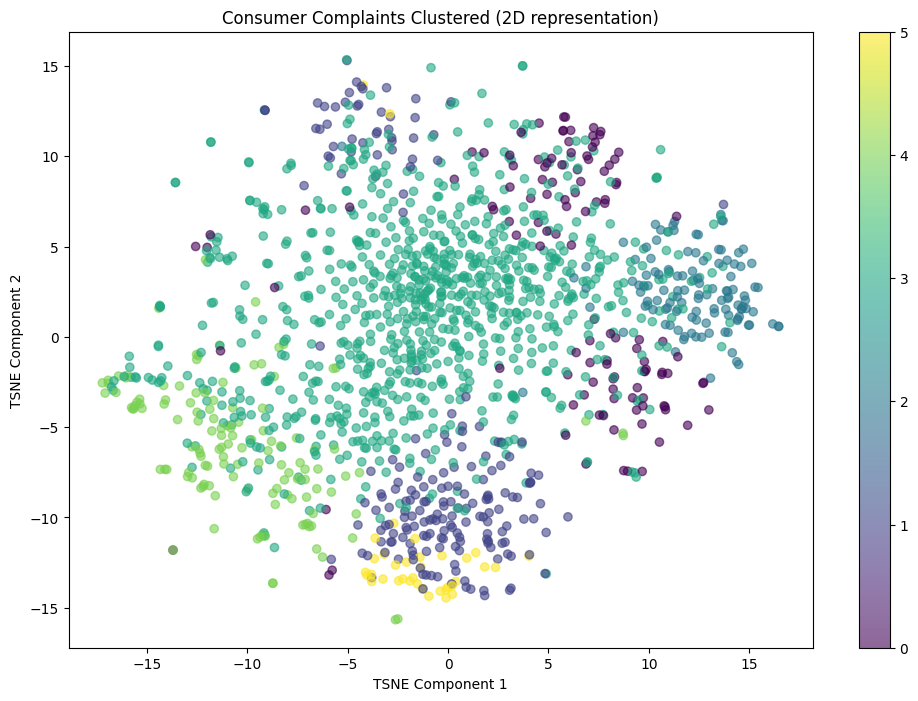

In [18]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

# Assuming 'X' is the NumPy array containing your high-dimensional embeddings
# and 'clusters' contains the corresponding cluster labels

# Reduce dimensions to 2D
tsne = TSNE(n_components=2, random_state=42)
X_reduced = tsne.fit_transform(train_vect.toarray())

# Plotting the clusters in 2D
plt.figure(figsize=(12, 8))
scatter = plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=clusters, cmap='viridis', alpha=0.6)
plt.colorbar(scatter)
plt.title('Consumer Complaints Clustered (2D representation)')
plt.xlabel('TSNE Component 1')
plt.ylabel('TSNE Component 2')
plt.show()

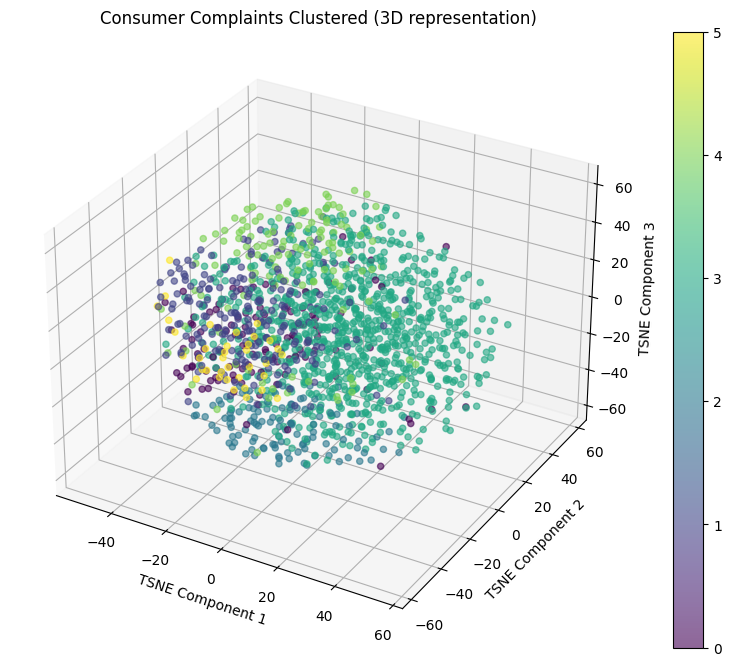

In [21]:
from mpl_toolkits.mplot3d import Axes3D
from sklearn.manifold import TSNE

# Reduce dimensions to 3D
tsne = TSNE(n_components=3, random_state=42)
X_reduced_3d = tsne.fit_transform(train_vect.toarray())

# Plotting the clusters in 3D
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(X_reduced_3d[:, 0], X_reduced_3d[:, 1], X_reduced_3d[:, 2],
                     c=clusters, cmap='viridis', alpha=0.6)
fig.colorbar(scatter)
ax.set_title('Consumer Complaints Clustered (3D representation)')
ax.set_xlabel('TSNE Component 1')
ax.set_ylabel('TSNE Component 2')
ax.set_zlabel('TSNE Component 3')
plt.show()

In [23]:
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer

# Aggregate texts in each cluster
clustered_texts = {i: [] for i in range(num_clusters)}

# Assume 'clusters' contains the cluster labels for each text
for i, cluster in enumerate(clusters):
    clustered_texts[cluster].append(cleaned_dataset['Consumer complaint narrative'].iloc[i])

# Analyze topics by the most frequent terms in each cluster
vectorizer = CountVectorizer(stop_words='english', max_features=1000)
for i in range(num_clusters):
    # Vectorize the texts in each cluster
    X_cluster = vectorizer.fit_transform(clustered_texts[i])
    # Sum word counts for each term in the cluster
    total_counts = np.array(X_cluster.sum(axis=0))[0]
    # Get the vocabulary mapping
    terms = vectorizer.get_feature_names_out()
    # Find the most frequent terms
    freq_terms = sorted(list(zip(terms, total_counts)), key=lambda x: x[1], reverse=True)[:10]
    print(f"Cluster {i}:")
    for term, freq in freq_terms:
        print(f"    {term}: {freq}")

Cluster 0:
    money: 748
    moneygram: 350
    informed: 197
    number: 197
    transaction: 178
    transfer: 173
    received: 172
    information: 170
    account: 155
    called: 146
Cluster 1:
    paypal: 1193
    account: 519
    credit: 234
    funds: 222
    payment: 221
    money: 212
    received: 179
    card: 176
    transaction: 171
    ebay: 155
Cluster 2:
    western: 649
    union: 601
    money: 447
    transaction: 207
    transfer: 197
    received: 179
    number: 146
    bank: 138
    informed: 138
    funds: 133
Cluster 3:
    money: 1099
    account: 875
    transfer: 640
    bank: 608
    received: 551
    funds: 530
    transaction: 394
    sent: 376
    informed: 351
    payment: 337
Cluster 4:
    bank: 835
    account: 747
    transfer: 491
    funds: 378
    money: 372
    wire: 280
    informed: 186
    number: 184
    received: 184
    wells: 180
Cluster 5:
    paypal: 454
    account: 319
    money: 102
    bank: 88
    payment: 86
    ebay: 75
    cr

In [24]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.decomposition import LatentDirichletAllocation

# Consider a CountVectorizer with both unigrams and bigrams.
vectorizer = CountVectorizer(ngram_range=(1, 3), stop_words='english')

# Apply the vectorizer to the text data
X = vectorizer.fit_transform(cleaned_dataset['Consumer complaint narrative'])

# Transform the count matrix to a normalized tf or tf-idf representation
tfidf_transformer = TfidfTransformer()
X_tfidf = tfidf_transformer.fit_transform(X)

# Fit the LDA model
lda = LatentDirichletAllocation(n_components=5, random_state=0)
lda.fit(X_tfidf)

# Feature names
feature_names = vectorizer.get_feature_names_out()

# Function to display topics
def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("Topic %d:" % (topic_idx))
        print(" ".join([feature_names[i]
                        for i in topic.argsort()[:-no_top_words - 1:-1]]))

# Display the topics
display_topics(lda, feature_names, no_top_words=10)

Topic 0:
money paypal bank account western transfer funds western union union moneygram
Topic 1:
paypal account money western bank union western union transfer funds payment
Topic 2:
paypal account money bank transfer received funds western western union union
Topic 3:
account paypal money transfer bank union western funds western union refund
Topic 4:
money paypal account bank transfer funds western union western union received


In [ ]:
def train_model(num_clusters, train_vectors):
  kmeans = KMeans(n_clusters=num_clusters, random_state=42)
  kmeans.fit(train_vect)
  clusters = kmeans.predict(train_vect)
  centroids = kmeans.cluster_centers_
  return clusters, centroids


def predict(test_sentences, test_labels, vectorizer, model):
  test_sentences = [" ".join(t) for t in  test_sentences]
  test_vect = vectorizer.transform(test_sentences)
  preds = model.predict(test_vect)
  acc = accuracy_score(test_labels, preds)
  return preds, acc
